# Application sur un dataset d'images en couleur


In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Présentation du dataset CIFAR-10


Dans cette application, nous allons utiliser le dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Il contient 60 000 images en couleur de taille $3 \times 32 \times 32$, réparties en 10 classes.
Les classes sont : avion, automobile, oiseau, chat, cerf, chien, grenouille, cheval, bateau et camion.
Nous allons charger le dataset avec torchvision :


In [3]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Transformation des données, normalisation et transformation en tensor pytorch
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Téléchargement et chargement du dataset
dataset = torchvision.datasets.CIFAR10(root='./../data', train=True,download=True, transform=transform)
testdataset = torchvision.datasets.CIFAR10(root='./../data', train=False,download=True, transform=transform)
print("taille d'une image : ",dataset[0][0].shape)

#Création des dataloaders pour le train, validation et test
train_dataset, val_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,shuffle=True, num_workers=2)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
taille d'une image :  torch.Size([3, 32, 32])


On peut visualiser les images et leurs classes :


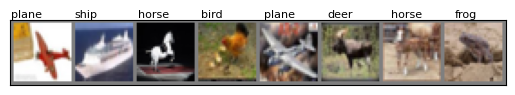

In [3]:
def imshow_with_labels(img, labels):
  img = img / 2 + 0.5  # Dénormaliser
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.xticks([])  # Supprimer les graduations sur l'axe des x
  plt.yticks([])  # Supprimer les graduations sur l'axe des y
  for i in range(len(labels)):
    plt.text(i * 35, -2, classes[labels[i]], color='black', fontsize=8, ha='left')

# Récupération d'un batch d'images
images, labels = next(iter(train_loader))

# Affichage des images avec leurs classes
imshow_with_labels(torchvision.utils.make_grid(images[:8]), labels[:8])
plt.show()

## Conception d'un réseau convolutif pour ce problème


Dans le cours sur les convolutions, nous avons vu le paramètre *stride*, qui correspond au pas de la convolution. Avec un *stride* de 2, la résolution de l'image est divisée par deux à la fin de l'opération (à condition que le *padding* compense la taille du filtre). Ainsi, l'opération de *pooling* peut être remplacée par une augmentation du *stride*.
La sortie d'une couche de convolution avec un *stride* de 1 suivie d'une couche de *pooling* est de même dimension que celle d'une couche de convolution avec un *stride* de 2 sans *pooling*.

Dans cette application, nous allons remplacer les couches de *pooling* par une augmentation du *stride* des convolutions.
Pour en savoir plus, consultez le [blogpost](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Difference-Between-Strided-Convolution-and-Pooling---VmlldzoyMDE5Mjc) ou l'[article](https://arxiv.org/abs/1412.6806).


In [4]:
class cnn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=nn.Conv2d(3,8,kernel_size=3,stride=2,padding=1)
    self.conv2=nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1)
    self.conv3=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1)
    self.fc=nn.Linear(4*4*32,10)
  
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,4*4*32)
    output=self.fc(x)
    return output

In [5]:
model = cnn() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Nombre de paramètres 11162


## Entraînement du modèle


In [6]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 1.5988761186599731
step 0 val loss 1.4532517194747925
step 1 train loss 1.3778905868530273
step 1 val loss 1.3579093217849731
step 2 train loss 1.2898519039154053
step 2 val loss 1.2919617891311646
step 3 train loss 1.2295998334884644
step 3 val loss 1.256637692451477
step 4 train loss 1.186734914779663
step 4 val loss 1.240902304649353


On peut maintenant vérifier la précision sur les données de test :


In [8]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  55.92


### Utilisation d'un GPU


Si vous avez un GPU sur votre ordinateur ou accès à un service cloud avec GPU, vous pouvez accélérer l'entraînement et l'inférence de votre modèle.
Voici comment procéder avec PyTorch :


In [9]:
model = cnn().to('cuda') # Ajouter le .to('cuda') pour charger le modèle sur GPU

In [10]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [11]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    images=images.to('cuda') # Ajouter le .to('cuda') pour charger les images sur GPU
    labels=labels.to('cuda') # Ajouter le .to('cuda') pour charger les labels sur GPU
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad():
      images=images.to('cuda')
      labels=labels.to('cuda')
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


step 0 train loss 1.6380540132522583
step 0 val loss 1.4465171098709106
step 1 train loss 1.369913101196289
step 1 val loss 1.3735681772232056
step 2 train loss 1.2817057371139526
step 2 val loss 1.2942956686019897
step 3 train loss 1.2238909006118774
step 3 val loss 1.2601954936981201
step 4 train loss 1.186323881149292
step 4 val loss 1.2583365440368652


In [12]:
correct = 0
total = 0
for images,labels in test_loader: 
  images=images.to('cuda')
  labels=labels.to('cuda')
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  55.76


Selon votre GPU, vous avez probablement remarqué une augmentation de la vitesse d'entraînement et d'inférence du modèle. Cette différence de vitesse est encore plus marquée avec des GPU puissants et des modèles profonds et parallélisables.


### Exercice pratique


Pour vous entraîner, essayez d'améliorer les performances du modèle sur le dataset CIFAR-10. Vous pouvez :
- Augmenter le nombre de couches
- Changer le nombre de filtres par couche
- Ajouter du *dropout*
- Utiliser la *batchnorm*
- Augmenter le nombre d'*epochs*
- Modifier le *learning rate*
Essayez d'atteindre au moins 70% de précision.
